# Model Training

This script is intended to load the clean *Amazon Reviews* training and testing datasets and use them to find the most suitable LSTM model to predict the class (1=negative, 2=positive) corresponding to each review in Amazon.

In [1]:
# Loading the necessary libraries
import numpy as np
import pandas as pd
import random
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split, KFold, cross_val_score


#Init random seed to get reproducible results
seed = 1111
random.seed(seed)
np.random.RandomState(seed)
torch.manual_seed(seed)

## Data loading

In [2]:
# We preset data types in advance, to save memory
dtypes = {
        'class' : 'uint8',
        'review_text' : 'str'
}
train_dataset = pd.read_csv("../input/amazon-reviews-clean/clean_amazon_reviews_train.csv", dtype=dtypes)
train_dataset

,class,review_text
0,2,I got this toy a couple of days ago and I ABSO...
1,2,Though lyrically the overall feel of this reco...
2,2,I have been looking for an anthology of outsta...
3,1,I tried/own both the pink and the orangish col...
4,2,Good coffee pot. Hot coffee. 6-8 cups makes a ...
...,...,...
899995,1,"Innocents, by Cathy Coote, is really a dreadfu..."
899996,2,Nena really gives us a top-notch album with th...
899997,2,"Being a humongous Kasey Chambers fan, I hunker..."
899998,1,I can't say much about this...just that it's a...


In [3]:
# We preset data types in advance, to save memory
dtypes = {
        'class' : 'uint8',
        'review_text' : 'str'
}
test_dataset = pd.read_csv("../input/amazon-reviews-clean/clean_amazon_reviews_test.csv", dtype=dtypes)
test_dataset

,class,review_text
0,1,"This is a good read for sure, but the problem ..."
1,2,I got this as a gift for my 10 year old nephew...
2,1,"According to the author, if you work hard, you..."
3,1,"Rambling and pointless, this overhyped tome se..."
4,2,Having read much about the exploits of Octavia...
...,...,...
99995,2,"The actual title is ""Made in Japan"", not ""2"". ..."
99996,1,I read this book. It was written fairly well b...
99997,1,I watched this film because I know one of the ...
99998,1,If there ever was a writer whose entire opus c...


## Preliminary steps

In [4]:
class Dictionary(object):
    def __init__(self):
        self.token2idx = {}
        self.idx2token = []

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def __len__(self):
        return len(self.idx2token)

In [5]:
char_vocab = Dictionary()
pad_token = '<pad>' # reserve index 0 for padding
unk_token = '<unk>' # reserve index 1 for unknown token
pad_index = char_vocab.add_token(pad_token)
unk_index = char_vocab.add_token(unk_token)

# join all the training sentences in a single string
# and obtain the list of different characters with set
chars = set(''.join(train_dataset['review_text']))
for char in sorted(chars):
    char_vocab.add_token(char)
print("Vocabulary:", len(char_vocab), "UTF characters")

class_vocab = Dictionary()
# use python set to obtain the list of languages without repetitions
classes = set(train_dataset['class'])
for c in sorted(classes):
    class_vocab.add_token(c)
print("Labels:", len(class_vocab), "classes")


Vocabulary: 151 UTF characters
Labels: 2 classes


In [6]:
#From token or label to index
x_train_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in train_dataset['review_text']]
y_train_idx = np.array([class_vocab.token2idx[cl] for cl in train_dataset['class']])
print(y_train_idx[0], x_train_idx[0][:10])

1 [52 11 82 90 95 11 95 83 84 94]


A validation procedure will be done to find the optimal parameters for the model. Hence, the training dataset is split (0.85 // 0.15):

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train_idx, y_train_idx, test_size=0.15, random_state=seed)
train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
print(len(train_data), "training samples")
print(len(val_data), "validation samples")

765000 training samples
135000 validation samples


## Model definition

The necessary functions for applying a LSTM model are defined next.

In [8]:
def batch_generator(data, batch_size, token_size):
    """Yield elements from data in chunks with a maximum of batch_size sequences and token_size tokens."""
    minibatch, sequences_so_far, tokens_so_far = [], 0, 0
    for ex in data:
        seq_len = len(ex[0])
        if seq_len > token_size:
            ex = (ex[0][:token_size], ex[1])
            seq_len = token_size
        minibatch.append(ex)
        sequences_so_far += 1
        tokens_so_far += seq_len
        if sequences_so_far == batch_size or tokens_so_far == token_size:
            yield minibatch
            minibatch, sequences_so_far, tokens_so_far = [], 0, 0
        elif sequences_so_far > batch_size or tokens_so_far > token_size:
            yield minibatch[:-1]
            minibatch, sequences_so_far, tokens_so_far = minibatch[-1:], 1, len(minibatch[-1][0])
    if minibatch:
        yield minibatch

In [9]:
def pool_generator(data, batch_size, token_size, shuffle=False):
    """Sort within buckets, then batch, then shuffle batches.
    Partitions data into chunks of size 100*token_size, sorts examples within
    each chunk, then batch these examples and shuffle the batches.
    """
    for p in batch_generator(data, batch_size * 100, token_size * 100):
        p_batch = batch_generator(sorted(p, key=lambda t: len(t[0]), reverse=True), batch_size, token_size)
        p_list = list(p_batch)
        if shuffle:
            for b in random.sample(p_list, len(p_list)):
                yield b
        else:
            for b in p_list:
                yield b

In [10]:
class CharRNNClassifier(torch.nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, output_size, model="lstm", num_layers=2,
                 bidirectional=False, pad_idx=0):
        super().__init__()
        self.model = model.lower()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(input_size, embedding_size, padding_idx=pad_idx)
        if self.model == "gru":
            self.rnn = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        elif self.model == "lstm":
            self.rnn = torch.nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, input, input_lengths):
        # T x B
        encoded = self.embed(input)
        # T x B x E
        packed = torch.nn.utils.rnn.pack_padded_sequence(encoded, input_lengths)
        # Packed T x B x E
        output, _ = self.rnn(packed)
        # Packed T x B x H
        # Important: you may need to replace '-inf' with the default zero padding for other pooling layers
        padded_mean, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=0.0)
        padded_max, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=float('-inf'))
        # T x B x H
        max_layer, _ = padded_max.max(dim=0)
        mean_layer = padded_mean.mean(dim=0)
        
        output = max_layer + mean_layer
        
        # B x H
        output = self.h2o(output)
        # B x O
        return output

In [11]:
if not torch.cuda.is_available():
    print("WARNING: CUDA is not available. Select 'GPU On' on kernel settings")
device = torch.device("cuda")
torch.cuda.manual_seed(seed)

In [12]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [13]:
def train(model, optimizer, data, batch_size, token_size, max_norm, log=False):
    model.train()
    total_loss = 0
    ncorrect = 0
    nsentences = 0
    ntokens = 0
    niterations = 0
    for batch in pool_generator(data, batch_size, token_size, shuffle=True):
        # Get input and target sequences from batch
        X = [torch.from_numpy(d[0]) for d in batch]
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long)
        y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
        # Pad the input sequences to create a matrix
        X = torch.nn.utils.rnn.pad_sequence(X).to(device)
        model.zero_grad()
        output = model(X, X_lengths)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)      # Gradient clipping
        optimizer.step()
        # Training statistics
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        nsentences += y.numel()
        niterations += 1
    
    total_loss = total_loss / nsentences
    accuracy = 100 * ncorrect / nsentences
    if log:
        print(f'Train: wpb={ntokens//niterations}, bsz={nsentences//niterations}, num_updates={niterations}')
    return accuracy

In [14]:
def validate(model, data, batch_size, token_size):
    model.eval()
    # calculate accuracy on validation set
    ncorrect = 0
    nsentences = 0
    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            # Get input and target sequences from batch
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
            y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            ncorrect += (torch.max(answer, 1)[1] == y).sum().item()
            nsentences += y.numel()
        dev_acc = 100 * ncorrect / nsentences
    return dev_acc

## Training and validation

In [15]:
# Definition of hyperparameter values
BATCH_SIZE = 256
TOKEN_SIZE = 200000
EPOCHS = 20
MAX_NORM = 1
HIDDEN_SIZE = 256
EMBEDDING_SIZE = 32

**To be done: implement an automated hyperparameter selection procedure**

In [16]:
# Assignation of hyperparameter values
hidden_size = HIDDEN_SIZE
embedding_size = EMBEDDING_SIZE
bidirectional = False
batch_size, token_size = BATCH_SIZE, TOKEN_SIZE
epochs = EPOCHS
max_norm = MAX_NORM

ntokens = len(char_vocab)
nlabels = len(class_vocab)

In [17]:
def get_model():
    model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    return model, optimizer

**Training loop**

In [18]:
train_accuracy = []
valid_accuracy = []
model, optimizer = get_model()
print(f'Training cross-validation model for {epochs} epochs')
t0 = time.time()
for epoch in range(1, epochs + 1):
    acc = train(model, optimizer, train_data, batch_size, token_size, max_norm, log=epoch==1)
    train_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | train accuracy={acc:.1f}% ({time.time() - t0:.0f}s)')
    acc = validate(model, val_data, batch_size, token_size)
    valid_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | valid accuracy={acc:.1f}%')

Training cross-validation model for 20 epochs
Train: wpb=101707, bsz=250, num_updates=3048
| epoch 001 | train accuracy=85.0% (468s)
| epoch 001 | valid accuracy=90.4%
| epoch 002 | train accuracy=91.4% (954s)
| epoch 002 | valid accuracy=92.2%
| epoch 003 | train accuracy=92.8% (1441s)
| epoch 003 | valid accuracy=92.8%
| epoch 004 | train accuracy=93.6% (1933s)
| epoch 004 | valid accuracy=92.7%
| epoch 005 | train accuracy=94.3% (2418s)
| epoch 005 | valid accuracy=93.1%
| epoch 006 | train accuracy=94.9% (2907s)
| epoch 006 | valid accuracy=93.1%
| epoch 007 | train accuracy=95.4% (3392s)
| epoch 007 | valid accuracy=92.9%
| epoch 008 | train accuracy=95.9% (3880s)
| epoch 008 | valid accuracy=93.1%
| epoch 009 | train accuracy=96.3% (4368s)
| epoch 009 | valid accuracy=93.0%
| epoch 010 | train accuracy=96.7% (4855s)
| epoch 010 | valid accuracy=92.7%
| epoch 011 | train accuracy=97.0% (5346s)
| epoch 011 | valid accuracy=92.8%
| epoch 012 | train accuracy=97.1% (5833s)
| epoch 01

In [19]:
print(model)
for name, param in model.named_parameters():
    print(f'{name:20} {param.numel()} {list(param.shape)}')
print(f'TOTAL                {sum(p.numel() for p in model.parameters())}')

CharRNNClassifier(
  (embed): Embedding(151, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4832 [151, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828642


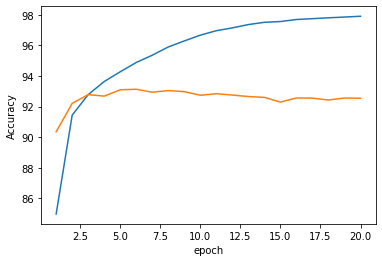

In [20]:
plt.plot(range(1, len(train_accuracy)+1), train_accuracy)
plt.plot(range(1, len(valid_accuracy)+1), valid_accuracy)
plt.xlabel('epoch')
plt.ylabel('Accuracy');

**Training the final model**

In [21]:
"""def log_mlflow(model):
    # Track params and metrics 
    with mlflow.start_run() as run:
        mlflow.set_tag("model_name", name)
        mlflow.log_metric("accuracy", acc)
        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)
    mlflow.end_run()"""

'def log_mlflow(model):\n    # Track params and metrics \n    with mlflow.start_run() as run:\n        mlflow.set_tag("model_name", name)\n        mlflow.log_metric("accuracy", acc)\n        # Save model to artifacts\n        mlflow.sklearn.log_model(model, name)\n    mlflow.end_run()'

In [22]:
"""from mlflow.models import MetricThreshold
thresholds = {
    "accuracy_score": MetricThreshold(
        threshold=0.8,             # accuracy should be >=0.8
        min_absolute_change=0.05,  # accuracy should be at least 0.05 greater than baseline model accuracy
        min_relative_change=0.05,  # accuracy should be at least 5 percent greater than baseline model accuracy
        higher_is_better=True
    ),
}"""

'from mlflow.models import MetricThreshold\nthresholds = {\n    "accuracy_score": MetricThreshold(\n        threshold=0.8,             # accuracy should be >=0.8\n        min_absolute_change=0.05,  # accuracy should be at least 0.05 greater than baseline model accuracy\n        min_relative_change=0.05,  # accuracy should be at least 5 percent greater than baseline model accuracy\n        higher_is_better=True\n    ),\n}'

In [23]:
print(f'Training final model for {epochs} epochs')
model, optimizer = get_model()
t0 = time.time()
for epoch in range(1, epochs - 20):
    acc = train(model, optimizer, train_data + val_data, batch_size, token_size, max_norm, log=epoch==1)
    print(f'| epoch {epoch:03d} | train accuracy={acc:.3f} ({time.time() - t0:.0f}s)')
    if epoch == epochs:
        print("The accuracy of the model is:", acc)

Training final model for 20 epochs


In [24]:
pickle.dump(model, open("model_256_200000_20_1_256_32.sav", 'wb'))

## Testing

To be done...